In [1]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
from acousticnn.mmo import get_dataloader, Iter_Dataset
from acousticnn.mmo import train
from acousticnn.utils.builder import build_opti_sche, build_model
from acousticnn.utils.logger import init_train_logger, print_log
from acousticnn.utils.argparser import get_args, get_config
from torchinfo import summary
import wandb 
import time
import os
import torch
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.labelsize'] = 10
rcParams['axes.titlesize'] = 10
rcParams["figure.figsize"] = (10 / 2.54, 8 / 2.54)

In [2]:
def plot_loss(losses_per_f, f, ax=None, quantile=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    losses_per_f = losses_per_f.transpose(0, 2, 1).reshape(-1, 200)
    mean = np.mean(losses_per_f, axis=0)
    std = np.std(losses_per_f, axis=0)
    ax.semilogx(f, mean)
    if quantile is not None:
        quantiles = np.quantile(losses_per_f, [0+quantile, 1-quantile], axis=0)
        ax.fill_between(f, quantiles[0], quantiles[1], alpha=0.2)

    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('rmse dB re 1m')
    return ax

def plot_results(prediction, amplitude, f, ax=None, quantile=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(7, 12))

    ax.semilogx(f, prediction, c='black', alpha = 0.8)
    ax.semilogx(f, amplitude, c='red', linestyle = 'dashed')

    ax.grid(True)
    ax.set_xlabel('Angular frequency in rad/s')
    ax.set_ylabel('Amplitude in dB re 1m')
    return ax

## get dataset>

In [3]:
args = get_args(["--config", "configs/explicit_mlp.yaml"])
args.encoding = "none"
config = get_config(args.config)

In [4]:
def get_dataloader_helper(n_masses, n_samples, test, batch_size):
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    parameters_dataset = {"n_masses": n_masses, 
            "sample_f": False,
            "f_per_sample": 200,
            "sample_m": True,
            "m_range": (1, 25),
            "sample_d": True,
            "d_range": (0.1, 1),
            "sample_k": True,
            "k_range": (1, 30),
            "normalize": False,
            "normalize_factor": 10,
            "f_range": (-1.5, 1)
    }    
    if args.encoding == "none":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "none"
    elif args.encoding == "random":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 10
        config.model.input_encoding = "random"
    elif args.encoding == "sin":
        parameters_dataset["normalize"] = True
        parameters_dataset["normalize_factor"] = 100
        config.model.input_encoding = "sin"
    else:
        raise NotImplementedError
    return get_dataloader(args, config, test=test, n_samples=n_samples, parameters=parameters_dataset, batch_size=batch_size)
valloader = get_dataloader_helper(4, 1000, True, 100)
f = np.logspace(-1.5, 1, 200)

{'n_masses': 4, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(12.9785) tensor(6.9809)
tensor(0.5434) tensor(0.2591)
tensor(15.3790) tensor(8.3880)
tensor(0.1859) tensor(2.4163)
tensor(-0.0086) tensor(2.7924)
tensor(-0.0660) tensor(2.5907)
tensor(-0.0403) tensor(2.7960)


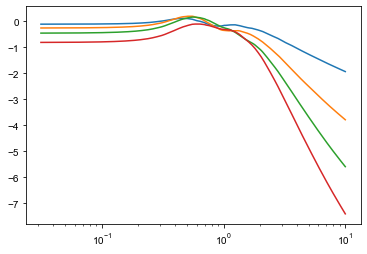

In [5]:
ref = torch.mean(valloader.dataset.amplitude, dim=0).unsqueeze(0)
plt.semilogx(f, ref[0])

## get predictions

In [6]:
def generate_prediction():
    pred, amp, losses, losses_per_f = [], [], [], []
    with torch.no_grad():
        for frequency, parameters, amplitude in valloader: 
            frequency, parameters, amplitude = frequency.to(args.device), [par.to(args.device) for par in parameters], amplitude.to(args.device)
            prediction = net(frequency, parameters) # B x num_masses x num_frequencies    
            prediction = prediction * 10
            amplitude = amplitude * 10
            loss = torch.nn.functional.mse_loss(prediction, amplitude)
            amplitude, prediction = amplitude.cpu(), prediction.cpu()
            pred.append(prediction), amp.append(amplitude), losses.append(loss.cpu())
            losses_per_f.append(torch.nn.functional.mse_loss(prediction, amplitude, reduction="none").detach().cpu().numpy())

    losses_per_f = np.vstack(losses_per_f)
    rmse_per_f = np.sqrt(losses_per_f)
    prediction, amplitude = np.vstack(pred)- ref.numpy(), np.vstack(amp)- ref.numpy()
    print(np.mean(losses_per_f)) 
    return prediction, amplitude, rmse_per_f

## Query frequency vs fixed grid

In [7]:
# fixed grid
config = get_config("configs/explicit_mlp.yaml")
config.model.input_encoding = "none"
args.device = "cpu"
path = r"C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\experiments\arch\no_encoding\explicitmlp\checkpoint_best"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond1, amplitude_cond1, losses_per_f_cond1 = generate_prediction()

0.92095


In [8]:
loss_per_sample_1 = np.mean(np.mean(losses_per_f_cond1, axis=1), axis=1)
print(np.argmin(loss_per_sample_1), np.argmax(loss_per_sample_1))
print(loss_per_sample_1[np.argmin(loss_per_sample_1)], loss_per_sample_1[np.argmax(loss_per_sample_1)])

706 730
0.21114866 1.7591101


In [9]:
# query frequency
config = get_config("configs/implicit_mlp.yaml")
config.model.input_encoding = "none"
path = r"C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\experiments\arch\no_encoding\implicitmlp\checkpoint_best"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()

0.10093473


In [10]:
loss_per_sample_2 = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample_2), np.argmax(loss_per_sample_2))
print(loss_per_sample_2[np.argmin(loss_per_sample_2)], loss_per_sample_2[np.argmax(loss_per_sample_2)])

757 20
0.07259707 0.73962593


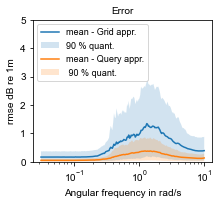

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot.set_title("Error")
plot.legend(["mean - Grid appr.","90 % quant.", "mean - Query appr.", " 90 % quant."], ncol = 1, prop = {'size': 9}, loc = 'upper left')
plot.set_ylim([0.0, 5.0])
plt.tight_layout()
fig.savefig("losses_query_fixed.png", format='png', dpi = 600)

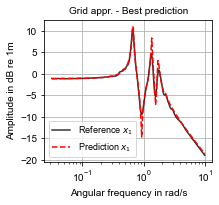

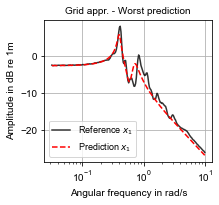

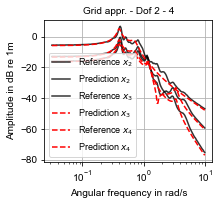

In [13]:
# Fixed grid plots
idx_min_loss_1 = np.argmin(loss_per_sample_2)
idx_max_loss_1 = np.argmax(loss_per_sample_2)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_min_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("Grid appr. - Best prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_fixed_best.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("Grid appr. - Worst prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_fixed_worst.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[1,2,3]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("Grid appr. - Dof 2 - 4")
plot.legend(["Reference $x_2$","Prediction $x_2$","Reference $x_3$","Prediction $x_3$","Reference $x_4$","Prediction $x_4$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_fixed_random.png", format='png', dpi = 600)

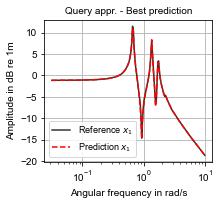

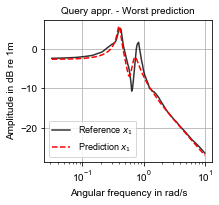

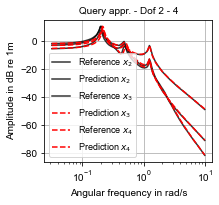

In [15]:
# Querry grid plots
idx_min_loss_2 = np.argmin(loss_per_sample_2)
idx_max_loss_2 = np.argmax(loss_per_sample_2)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_min_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Query appr. - Best prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_query_best.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_max_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Query appr. - Worst prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_query_worst.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[1,2,3]
num= idx_max_loss_1
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Query appr. - Dof 2 - 4")
plot.legend(["Reference $x_2$","Reference $x_3$","Reference $x_4$","Prediction $x_2$","Prediction $x_3$","Prediction $x_4$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_query_random.png", format='png', dpi = 600)

## mlp vs transformer

In [14]:
# mlp
config = get_config(r'C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\configs\implicit_mlp.yaml')
config.model.input_encoding = "none"
args.device = "cpu"
path = r"C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\experiments\arch\no_encoding\implicitmlp\checkpoint_best"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond1, amplitude_cond1, losses_per_f_cond1 = generate_prediction()


0.10093473


In [15]:
loss_per_sample_1 = np.mean(np.mean(losses_per_f_cond1, axis=1), axis=1)
print(np.argmin(loss_per_sample_1), np.argmax(loss_per_sample_1))
print(loss_per_sample_1[np.argmin(loss_per_sample_1)], loss_per_sample_1[np.argmax(loss_per_sample_1)])

757 20
0.07259707 0.73962593


In [16]:
# transformer
config = get_config(r'C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\configs\implicit_transformer.yaml')
config.model.input_encoding = "none"
path = r"C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\experiments\arch\no_encoding\implicit_transformer\checkpoint_best"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()


0.0047952817


In [17]:
loss_per_sample_2 = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample_2), np.argmax(loss_per_sample_2))
print(loss_per_sample_2[np.argmin(loss_per_sample_2)], loss_per_sample_2[np.argmax(loss_per_sample_2)])

211 730
0.009419805 0.17900318


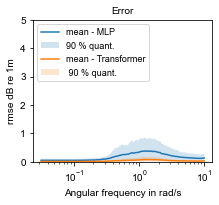

In [18]:
# Loss plots
fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot.set_title("Error")
plot.legend(["mean - MLP","90 % quant.", "mean - Transformer", " 90 % quant."], ncol = 1, prop = {'size': 9}, loc = 'upper left')
plot.set_ylim([0.0, 5.0])
plt.tight_layout()
fig.savefig("losses_MLP_Trans.png", format='png', dpi = 600)

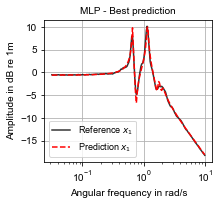

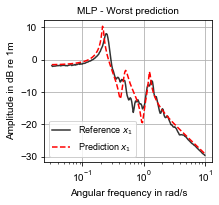

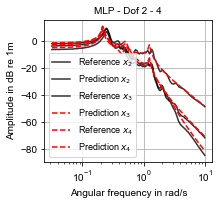

In [14]:
# MLP plots
idx_min_loss_1 = np.argmin(loss_per_sample_1)
idx_max_loss_1 = np.argmax(loss_per_sample_1)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_min_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP - Best prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_MLP_Best.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP - Worst prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_MLP_Worst.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[1,2,3]
num= idx_max_loss_1
plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax)
plot.set_title("MLP - Dof 2 - 4")
plot.legend(["Reference $x_2$","Prediction $x_2$","Reference $x_3$","Prediction $x_3$","Reference $x_4$","Prediction $x_4$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_MLP_Samples.png", format='png', dpi = 600)

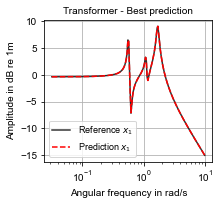

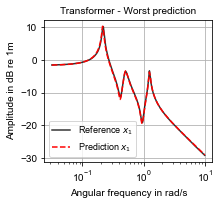

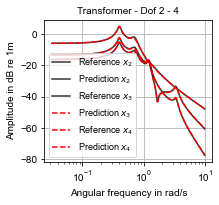

In [20]:
# Transformer plots
idx_min_loss_2 = np.argmin(loss_per_sample_2)
idx_max_loss_2 = np.argmax(loss_per_sample_2)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_min_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Transformer - Best prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_trans_best.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[0]
num= idx_max_loss_2
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Transformer - Worst prediction")
plot.legend(["Reference $x_1$","Prediction $x_1$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_trans_worst.png", format='png', dpi = 600)

fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
i=[1,2,3]
num= idx_max_loss_1
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)
plot.set_title("Transformer - Dof 2 - 4")
plot.legend(["Reference $x_2$","Prediction $x_2$","Reference $x_3$","Prediction $x_3$","Reference $x_4$","Prediction $x_4$"], prop = {'size': 9}, loc = 'lower left')
plt.tight_layout()
fig.savefig("samples_trans_random.png", format='png', dpi = 600)


## MSE over data amount TODO

Text(0, 0.5, 'MSE (log scale)')

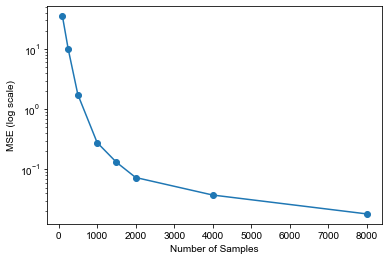

In [21]:
# see experiments/data_variation
n_samples = [100, 250, 500, 1000, 1500, 2000, 4000, 8000]
loss = [35.17, 9.987, 1.754, 0.2799, 0.1318, 0.07344, 0.03755,  0.01823]

plt.semilogy(n_samples, loss,  'o-')
plt.xlabel('Number of Samples')
plt.ylabel('MSE (log scale)')

### Variation on masses

In [24]:
path = r"C:\Users\Schultz\NextCloud\WorkingDir\Projects\D2A\Code\spp_ai_acoustics\acousticnn\mmo\experiments\mass_variation\checkpoint_best"
# transformer
config = get_config("configs/implicit_transformer.yaml")
config.model.input_encoding = "none"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path, map_location= "cpu")["model_state_dict"])
valloader = get_dataloader_helper(2, 1000, True, 16)
prediction_cond1, amplitude_cond1, losses_per_f_cond1 = generate_prediction()
loss_per_sample = np.mean(np.mean(losses_per_f_cond1, axis=1), axis=1)
print(np.argmin(loss_per_sample), np.argmax(loss_per_sample))
print(loss_per_sample[np.argmin(loss_per_sample)], loss_per_sample[np.argmax(loss_per_sample)])

{'n_masses': 2, 'sample_f': False, 'f_per_sample': 200, 'sample_m': True, 'm_range': (1, 25), 'sample_d': True, 'd_range': (0.1, 1), 'sample_k': True, 'k_range': (1, 30), 'normalize': True, 'normalize_factor': 10, 'f_range': (-1.5, 1)}
1 25
0.1 1
1 30
fix_f
Normalize
True
tensor(1.7482) tensor(2.4163)
tensor(13.0873) tensor(7.0796)
tensor(0.5433) tensor(0.2566)
tensor(15.3022) tensor(8.4322)
tensor(0.1859) tensor(2.4163)
tensor(0.0349) tensor(2.8318)
tensor(-0.0673) tensor(2.5663)
tensor(-0.0659) tensor(2.8107)


ValueError: operands could not be broadcast together with shapes (1000,200,2) (1,200,4) 

In [ ]:
valloader = get_dataloader_helper(3, 1000, True, 16)
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()
loss_per_sample = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample), np.argmax(loss_per_sample))
print(loss_per_sample[np.argmin(loss_per_sample)], loss_per_sample[np.argmax(loss_per_sample)])

In [ ]:
valloader = get_dataloader_helper(5, 1000, True, 16)
prediction_cond3, amplitude_cond3, losses_per_f_cond3 = generate_prediction()
loss_per_sample = np.mean(np.mean(losses_per_f_cond3, axis=1), axis=1)
print(np.argmin(loss_per_sample), np.argmax(loss_per_sample))
print(loss_per_sample[np.argmin(loss_per_sample)], loss_per_sample[np.argmax(loss_per_sample)])

In [ ]:
valloader = get_dataloader_helper(6, 1000, True, 16)
prediction_cond4, amplitude_cond4, losses_per_f_cond4 = generate_prediction()
loss_per_sample = np.mean(np.mean(losses_per_f_cond4, axis=1), axis=1)
print(np.argmin(loss_per_sample), np.argmax(loss_per_sample))
print(loss_per_sample[np.argmin(loss_per_sample)], loss_per_sample[np.argmax(loss_per_sample)])

In [ ]:
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot.set_title("Error")
plot.legend(["mean - Grid appr.","90 % quant.", "mean - Querry appr.", " 90 % quant."], ncol = 1, prop = {'size': 9}, loc = 'upper left')
plot.set_ylim([0.0, 5.0])
plt.tight_layout()
fig.savefig("losses_query_fixed.png", format='png', dpi = 600)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8 / 2.54, 7.5 / 2.54))
plot = plot_loss(losses_per_f_cond1, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond3, f, ax, quantile=0.1)
plot = plot_loss(losses_per_f_cond4, f, ax, quantile=0.1)
legend_labels = ["mean - 2 masses", "_", "mean - 3 masses", "_", "mean - 5 masses", "_", "mean - 6 masses", "_"]
ax.legend(legend_labels, ncol = 1, prop = {'size': 9}, loc = 'upper left')
plot.set_ylim([0.0, 2.0])
fig.savefig("losses.png", format='png', dpi = 600)

## Transfer TODO

In [ ]:
path = "/user/delden/acoustics/spp_ai_acoustics/acousticnn/mmo/experiments/mass_variation/checkpoint_best"
# transformer
config = get_config("configs/implicit_transformer.yaml")
config.model.input_encoding = "none"
net = build_model(valloader, args, config)
net.load_state_dict(torch.load(path)["model_state_dict"])
prediction_cond2, amplitude_cond2, losses_per_f_cond2 = generate_prediction()


loss_per_sample = np.mean(np.mean(losses_per_f_cond2, axis=1), axis=1)
print(np.argmin(loss_per_sample), np.argmax(loss_per_sample))
print(loss_per_sample[np.argmin(loss_per_sample)], loss_per_sample[np.argmax(loss_per_sample)])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
plot = plot_loss(losses_per_f_cond2, f, ax, quantile=0.15)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
i=[0,1,2, 3]
num= 973
#plot = plot_results(prediction_cond1[num][:,i], amplitude_cond1[num][:,i], f, ax[0])
plot = plot_results(prediction_cond2[num][:,i], amplitude_cond2[num][:,i], f, ax)

### finetune on 4 masses

In [ ]:
from acousticnn.mmo import train
from acousticnn.utils.builder import build_opti_sche
args.seed=1234

In [ ]:
trainloader = get_dataloader_helper(4, 100, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) # 16.83

In [ ]:
trainloader = get_dataloader_helper(4, 250, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) # 1.562

In [ ]:
trainloader = get_dataloader_helper(4, 500, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) #  0.6747

In [ ]:
trainloader = get_dataloader_helper(4, 1000, False, 16)
net.load_state_dict(torch.load(path)["model_state_dict"])
optimizer, scheduler = build_opti_sche(net, config)
config.epochs = 1000
config.scheduler.kwargs.epochs = config.epochs
config.scheduler.kwargs.initial_epochs = 50
train(args, config, net, trainloader, optimizer, valloader, scheduler=scheduler, logger=None) # 0.01

In [ ]:
# see experiments/data_variation
n_samples = [100, 250, 500, 1000, 1500, 2000, 4000, 8000]
loss = [35.17, 9.987, 1.754, 0.2799, 0.1318, 0.07344, 0.03755,  0.01823]

n_samples_finetuning = [100, 250, 500, 1000]
loss_finetuning = [22.96, 2.291, 0.6747, 0.2442]

plt.semilogy(n_samples, loss, 'o-', label='Training from scratch')
plt.semilogy(n_samples_finetuning, loss_finetuning, 'o-', label='Finetuning')

# Set labels and title
plt.xlabel('Number of Samples')
plt.ylabel('MSE (log scale)')
plt.title('Comparison of Training from Scratch and Finetuning')

# Add legend
plt.legend()